In [40]:
from scipy import signal

import sys
sys.path.append('../')

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from src.utilities.video import get_video_paths, create_video_info_dict, get_fps_list
from src.utilities.audio import get_audio_sample_rates, extract_audio_files, get_audio_paths_from_folder


[2023-08-25 23:04:40.0971] [   DEBUG] [matplotlib] [wrapper():320] [PID:44468 TID:54468] CACHEDIR=C:\Users\joshu\.matplotlib
[2023-08-25 23:04:40.0976] [   DEBUG] [matplotlib.font_manager] [_load_fontmanager():1543] [PID:44468 TID:54468] Using fontManager instance from C:\Users\joshu\.matplotlib\fontlist-v330.json


In [85]:
raw_video_folder = Path("C:\\users\\joshu\\benniemocap_data\\sessions\\session_2023-08-21_22_34_07\\synchronized_videos\\fr")
audio_folder = Path("C:\\users\\joshu\\benniemocap_data\\sessions\\session_2023-08-21_22_34_07\\synchronized_videos\\audio_files")

list_of_video_paths = list(Path(raw_video_folder).glob("*.mp4"))
video_info_dict = create_video_info_dict(list_of_video_paths)
audio_signal_dict = extract_audio_files(video_info_dict=video_info_dict, audio_extension="wav", audio_folder_path=audio_folder)

print (video_info_dict)
print (audio_signal_dict)

[2023-08-26 02:08:33.0349] [    INFO] [root] [extract_audio_files():38] [PID:44468 TID:54468] audio file CAM1.wav is 27.885714285714286 seconds long
[2023-08-26 02:08:33.0520] [    INFO] [root] [extract_audio_files():38] [PID:44468 TID:54468] audio file CAM2.wav is 33.50639455782313 seconds long
[2023-08-26 02:08:33.0705] [    INFO] [root] [extract_audio_files():38] [PID:44468 TID:54468] audio file CAM3.wav is 47.27437641723356 seconds long
{'CAM1': {'video_filepath': WindowsPath('C:/users/joshu/benniemocap_data/sessions/session_2023-08-21_22_34_07/synchronized_videos/fr/CAM1.mp4'), 'video_pathstring': 'C:\\users\\joshu\\benniemocap_data\\sessions\\session_2023-08-21_22_34_07\\synchronized_videos\\fr\\CAM1.mp4', 'camera_name': 'CAM1', 'video_duration': 27.878333, 'video_fps': 120.0}, 'CAM2': {'video_filepath': WindowsPath('C:/users/joshu/benniemocap_data/sessions/session_2023-08-21_22_34_07/synchronized_videos/fr/CAM2.mp4'), 'video_pathstring': 'C:\\users\\joshu\\benniemocap_data\\sess

In [38]:
fps_list = get_fps_list(video_info_dict=video_info_dict)
audio_sample_rates = get_audio_sample_rates(audio_signal_dict=audio_signal_dict)

print (fps_list)
print (audio_sample_rates)

[120.0, 120.0, 120.0]
[44100, 44100, 44100]


In [39]:
comparison_file_key = next(iter(audio_signal_dict))
print (comparison_file_key)

CAM1.wav


In [95]:
# Cross correlate all audio to the first audio file
sample_rate = audio_sample_rates[0]
audio1 = audio_signal_dict[comparison_file_key]["audio_file"]
audio2 = audio_signal_dict["CAM2.wav"]["audio_file"]
audio3 = audio_signal_dict["CAM3.wav"]["audio_file"]

correlation12 = signal.correlate(audio1, audio2, mode="full", method="fft")
correlation13 = signal.correlate(audio1, audio3, mode="full", method="fft")
correlation11 = signal.correlate(audio1, audio1, mode="full", method="fft")

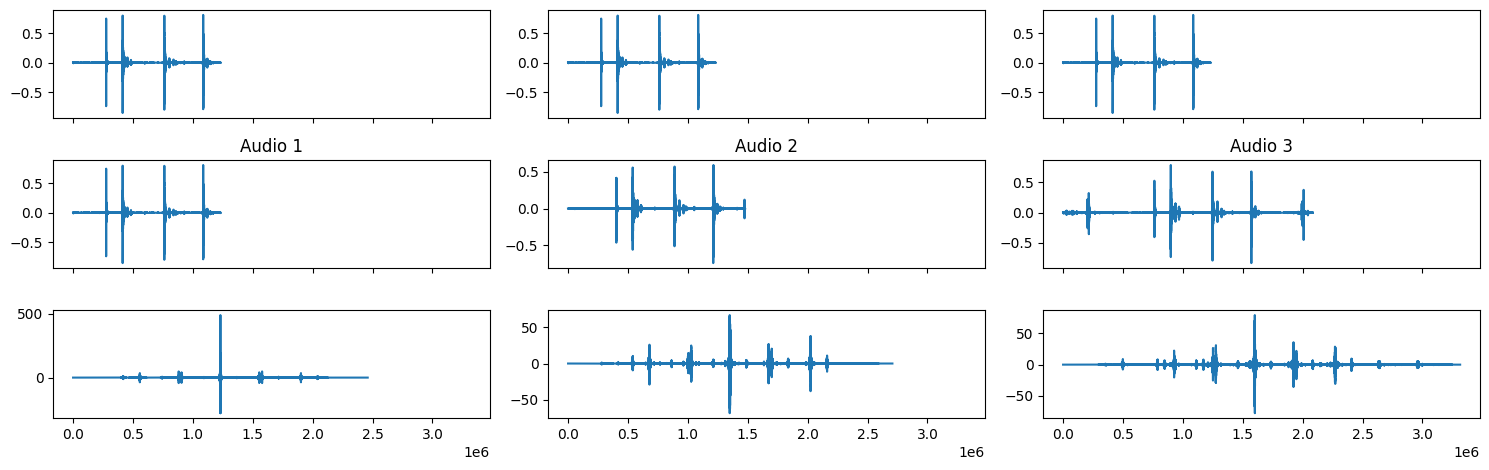

In [96]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex=True)
fig.set_figwidth(15)
ax1.plot(audio1)
ax2.plot(audio1)
ax3.plot(audio1)

ax4.plot(audio1)
ax4.set_title("Audio 1")
ax5.plot(audio2)
ax5.set_title("Audio 2")
ax6.plot(audio3)
ax6.set_title("Audio 3")

ax7.plot(correlation11)
ax8.plot(correlation12)
ax9.plot(correlation13)

fig.tight_layout()



In [97]:
lags11 = signal.correlation_lags(audio1.size, audio1.size, mode="full")
lags12 = signal.correlation_lags(audio1.size, audio2.size, mode="full")
lags13 = signal.correlation_lags(audio1.size, audio3.size, mode="full")

idx_11 = np.argmax(correlation11)
idx_12 = np.argmax(correlation12)
idx_13 = np.argmax(correlation13)

lag11 = lags11[np.argmax(correlation11)]
lag12 = lags12[np.argmax(correlation12)]
lag13 = lags13[np.argmax(correlation13)]

print(lags11)
print (lags12)
print (lags13)

print(lag11)
print(lag12)
print(lag13)



[-1229759 -1229758 -1229757 ...  1229757  1229758  1229759]
[-1477631 -1477630 -1477629 ...  1229757  1229758  1229759]
[-2084799 -2084798 -2084797 ...  1229757  1229758  1229759]
0
-128591
-484395


In [98]:
lag_dict = {
    "CAM1.wav" : lag11 / sample_rate,
    "CAM2.wav" : lag12 / sample_rate,
    "CAM3.wav" : lag13 / sample_rate
}

print (lag_dict)

normalized_lag_dict = {camera_name: (max(lag_dict.values()) - value) for camera_name, value in lag_dict.items()}

print (normalized_lag_dict)

{'CAM1.wav': 0.0, 'CAM2.wav': -2.915895691609977, 'CAM3.wav': -10.984013605442177}
{'CAM1.wav': 0.0, 'CAM2.wav': 2.915895691609977, 'CAM3.wav': 10.984013605442177}


In [99]:
minimum_duration = min(video_dict["video_duration"] - lag_dict[video_dict["camera_name"]+".wav"] for video_dict in video_info_dict.values())

for video_dict in video_info_dict.values():
    print (video_dict["video_duration"])
print (minimum_duration)

27.878333
33.505
47.255
27.878333


In [100]:
minimum_frames = int(minimum_duration * 120.0)
print (minimum_frames)

3345


In [101]:
for video_dict in video_info_dict.values():
    video_name = video_dict["camera_name"]
    start_time = lag_dict[video_dict["camera_name"]+".wav"]
    start_frame = int(start_time * 120.0)
    frame_list = [start_frame + frame for frame in range(minimum_frames)]
    print (video_name + " | " + str(start_time) + " | " + str(start_frame))
    

CAM1 | 0.0 | 0
CAM2 | -2.915895691609977 | -349
CAM3 | -10.984013605442177 | -1318
